In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error

In [6]:
# Load data
df = pd.read_csv("/Users/mariahloehr/IICD/IICD/Data/cell_cycle_tidied.csv")

# Separate features and target
X = df.drop(columns=['phase', 'age', 'PHATE_1', 'PHATE_2'])  # drop non-feature columns
y = df['age']

In [7]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=949)

In [28]:
# Train-test split (optional, if you want separate test evaluation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=949)

# Fit Lasso regression with 10-fold CV to select best alpha
lasso_cv = LassoCV(alphas = (0.0001, 0.001, 0.01, 0.1, 1, 10), cv=10, random_state=949, max_iter = 1000)
lasso_cv.fit(X_train, y_train)

# Best alpha
print(f"Best alpha (lambda): {lasso_cv.alpha_:.5f}")
best_alpha = lasso_cv.alpha_

/Users/mariahloehr/IICD/IICD/sklearn-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.336e+01, tolerance: 1.729e+01
  model = cd_fast.enet_coordinate_descent_gram(
/Users/mariahloehr/IICD/IICD/sklearn-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.885e+03, tolerance: 1.729e+01
  model = cd_fast.enet_coordinate_descent_gram(
/Users/mariahloehr/IICD/IICD/sklearn-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sc

Best alpha (lambda): 0.01000


In [29]:
# Predict on training and test sets
y_train_pred = lasso_cv.predict(X_train)
y_test_pred = lasso_cv.predict(X_test)

In [30]:
# Calculate and print RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Train RMSE: {train_rmse:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")

rmse_mean = np.sqrt(np.mean(lasso_cv.mse_path_, axis=1))
rmse_std = np.std(np.sqrt(lasso_cv.mse_path_), axis=1)

alphas = lasso_cv.alphas_

min_idx = np.argmin(rmse_mean)
one_se_threshold = rmse_mean[min_idx] + rmse_std[min_idx]
one_se_alpha = alphas[rmse_mean <= one_se_threshold][-1]

print(f"Alpha with 1-SE Rule (using RMSE): {one_se_alpha:.5f}")

Train RMSE: 1.918
Test RMSE: 2.008
Alpha with 1-SE Rule (using RMSE): 0.00100


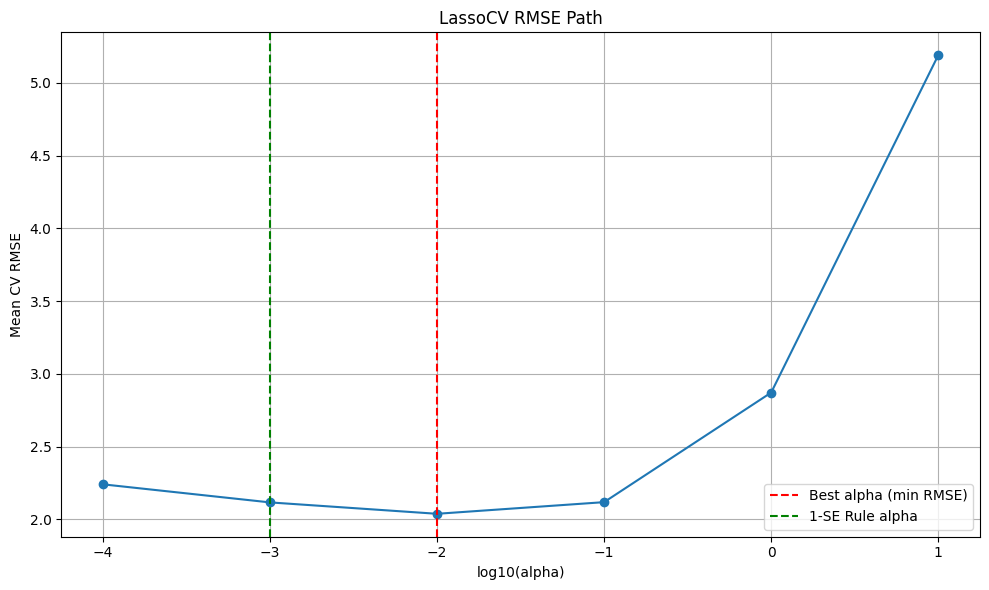

In [31]:
# Plot CV MSE path with 1-SE Rule
plt.figure(figsize=(10, 6))
plt.plot(np.log10(alphas), rmse_mean, '-o')
plt.axvline(np.log10(best_alpha), color='red', linestyle='--', label='Best alpha (min RMSE)')
plt.axvline(np.log10(one_se_alpha), color='green', linestyle='--', label='1-SE Rule alpha')
plt.xlabel('log10(alpha)')
plt.ylabel('Mean CV RMSE')
plt.title('LassoCV RMSE Path')
plt.legend()
plt.grid(True)
plt.tight_layout()

plot_path = "lasso_full_path.png"
plt.savefig(plot_path, dpi=300)
plt.show()

/Users/mariahloehr/IICD/IICD/sklearn-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.002e+01, tolerance: 1.906e+01
  model = cd_fast.enet_coordinate_descent(
/Users/mariahloehr/IICD/IICD/sklearn-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.628e+03, tolerance: 1.906e+01
  model = cd_fast.enet_coordinate_descent(


Alpha with minimum BIC: 0.01000


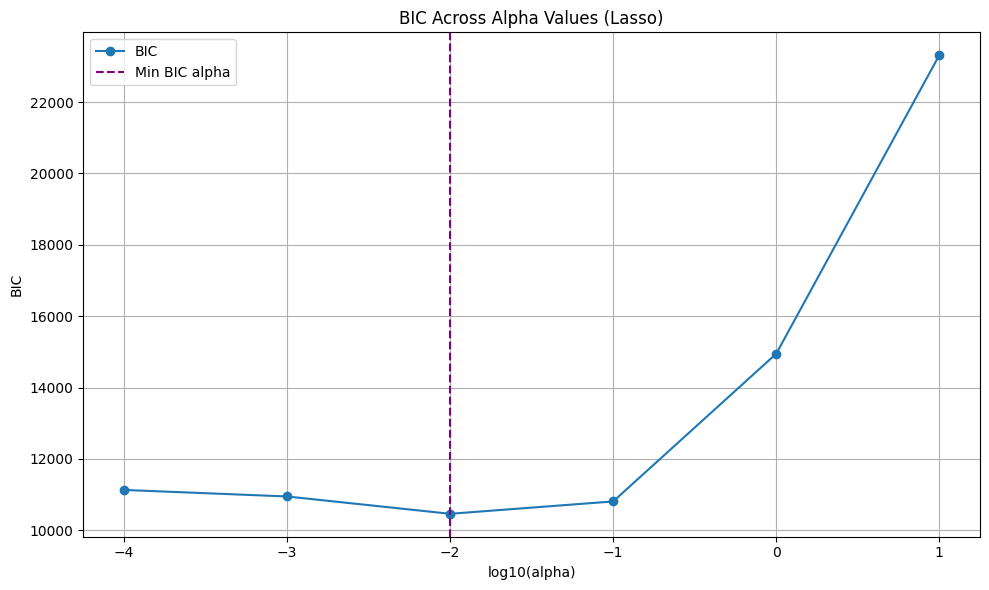

In [35]:
n = len(y_train)
bic_values = []

# Compute BIC for each alpha
for alpha in alphas:
    model = Lasso(alpha=alpha, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    rss = np.sum((y_train - y_pred) ** 2)
    k = np.sum(model.coef_ != 0)  # number of non-zero coefficients
    bic = n * np.log(rss / n) + k * np.log(n)
    bic_values.append(bic)

# Find alpha with minimum BIC
min_bic_idx = np.argmin(bic_values)
best_bic_alpha = alphas[min_bic_idx]
print(f"Alpha with minimum BIC: {best_bic_alpha:.5f}")

# Plot BIC
plt.figure(figsize=(10, 6))
plt.plot(np.log10(alphas), bic_values, 'o-', label='BIC')
plt.axvline(np.log10(best_bic_alpha), color='purple', linestyle='--', label='Min BIC alpha')
plt.xlabel('log10(alpha)')
plt.ylabel('BIC')
plt.title('BIC Across Alpha Values (Lasso)')
plt.legend()
plt.grid(True)
plt.tight_layout()

plot_path = "lasso_full_path_bic.png"
plt.savefig(plot_path, dpi=300)
plt.show()

In [32]:
# Retrain with alpha = 0.001
lasso_best_alpha = Lasso(alpha =0.001, random_state=949, max_iter = 1000)
lasso_best_alpha.fit(X_train, y_train)

best_alpha_y_train_pred = lasso_best_alpha.predict(X_train)
best_alpha_y_test_pred = lasso_best_alpha.predict(X_test)

/Users/mariahloehr/IICD/IICD/sklearn-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.002e+01, tolerance: 1.906e+01
  model = cd_fast.enet_coordinate_descent(


In [33]:
# Retrained with alpha = 0.001
rmse_train = root_mean_squared_error(y_train, best_alpha_y_train_pred)
rmse_test = root_mean_squared_error(y_test, best_alpha_y_test_pred)


print("=== Training Set ===")
print(f"RMSE: {rmse_train:.4f}")

print("\n=== Test Set ===")
print(f"RMSE: {rmse_test:.4f}")

# For training set
df_train = pd.DataFrame({
    'true_age': y_train,
    'pred_age': best_alpha_y_train_pred,
    'phase': df.loc[y_train.index, 'phase']  # get phase for train samples
})

rmse_per_phase_train = df_train.groupby('phase').apply(
    lambda x: root_mean_squared_error(x['true_age'], x['pred_age'])
)

print("RMSE per phase (Train):")
print(rmse_per_phase_train)

# For test set
df_test = pd.DataFrame({
    'true_age': y_test,
    'pred_age': best_alpha_y_test_pred,
    'phase': df.loc[y_test.index, 'phase']  # get phase for test samples
})

rmse_per_phase_test = df_test.groupby('phase').apply(
    lambda x: root_mean_squared_error(x['true_age'], x['pred_age'])
)

print("\nRMSE per phase (Test):")
print(rmse_per_phase_test)

=== Training Set ===
RMSE: 1.8746

=== Test Set ===
RMSE: 2.0933
RMSE per phase (Train):
phase
G0    1.982965
G1    1.502288
G2    2.274952
M     8.164779
S     1.688444
dtype: float64

RMSE per phase (Test):
phase
G0     2.083734
G1     1.717490
G2     2.504917
M     11.228791
S      1.780017
dtype: float64


/var/folders/1s/bvxr71hj0hqgyk_jk6k7wkm80000gn/T/ipykernel_69819/2887160636.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_per_phase_train = df_train.groupby('phase').apply(
/var/folders/1s/bvxr71hj0hqgyk_jk6k7wkm80000gn/T/ipykernel_69819/2887160636.py:33: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_per_phase_test = df_test.groupby('phase').apply(
